In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist
from collections import Counter

## Matching Approach Simulation

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

Therefore, for the heterogeneous constraints, I added a slack variable in the objective function with penalty to further relax the tolerance. 


In [2]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_weights_heterogeneous(X, Z):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("HeteroExactAll")
    model.setParam('OutputFlag', 0)
    w_vars = model.addVars(N, lb=0.0, name="w")

    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    # All interaction sets: (), (k,), (k1,k2), ..., (k1,...,kK)
    J_list = [()]
    for r in range(1, K + 1):
        J_list += list(combinations(range(K), r))
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.prod(Z[:, list(J)], axis=1) if J else np.ones(N)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_idx, z in enumerate(Z_all):
        for j_idx, J in enumerate(J_list):
            z_prod = np.prod([z[j] for j in J]) if J else 1.0
            for s in range(n_s):
                bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s])

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k in range(K):
        for z_idx, z in enumerate(Z_all):
            g_plus = 1.0 if z[k] == 1 else 0.0
            g_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * g_plus * bigQ[z_idx, s, j_idx]
                    target_minus[k, s, j_idx] += factor * g_minus * bigQ[z_idx, s, j_idx]

    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i] * w_vars[i]
    model.setObjective(obj, gp.GRB.MINIMIZE)

    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_plus == target_plus[k, s, j_idx])
                model.addConstr(lhs_minus == target_minus[k, s, j_idx])

    model.optimize()
    if model.status != gp.GRB.OPTIMAL:
        return None
    return np.array([w_vars[i].X for i in range(N)])

def solve_matching_heterogeneous(X, Z, lambda_penalty=100.0):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("MatchingAll")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=gp.GRB.BINARY, name="w")
    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    J_list = [()]
    for r in range(1, K+1):
        J_list += list(combinations(range(K), r))
    #J_list = [()] + [(j,) for j in range(K)]
    
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.prod(Z[:, list(J)], axis=1) if J else np.ones(N)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_idx, z in enumerate(Z_all):
        for j_idx, J in enumerate(J_list):
            z_prod = np.prod([z[j] for j in J]) if J else 1.0
            for s in range(n_s):
                bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s])

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k in range(K):
        for z_idx, z in enumerate(Z_all):
            g_plus = 1.0 if z[k] == 1 else 0.0
            g_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * g_plus * bigQ[z_idx, s, j_idx]
                    target_minus[k, s, j_idx] += factor * g_minus * bigQ[z_idx, s, j_idx]

    slack_vars = []
    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))

                tpos = model.addVar(lb=0.0)
                tneg = model.addVar(lb=0.0)
                tpos_m = model.addVar(lb=0.0)
                tneg_m = model.addVar(lb=0.0)
                model.addConstr(lhs_plus == target_plus[k, s, j_idx] + tpos - tneg)
                model.addConstr(lhs_minus == target_minus[k, s, j_idx] + tpos_m - tneg_m)

                slack_vars.extend([tpos, tneg, tpos_m, tneg_m])

    total_slack = gp.quicksum(slack_vars)
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * total_slack, gp.GRB.MAXIMIZE)

    model.optimize()
    if model.status != gp.GRB.OPTIMAL:
        return None
    return np.array([w_vars[i].X for i in range(N)])


def interaction_regression(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]
    design_list = [np.ones(N)]  # intercept

    # Add X and Z main effects
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])

    # Add 2-way interactions: X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])

    # Add 3-way interactions: X_j * Z_k * Z_l (k < l)
    for d_ in range(D):
        for k1 in range(K):
            for k2 in range(k1 + 1, K):
                design_list.append(X[:, d_] * Z[:, k1] * Z[:, k2])

    Xd = np.column_stack(design_list)
    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]  # main effect of Z_k
        out[k_ + 1] = 2 * zcoef
    return out

def estimate_main_effects_weighted(Y, Z, w):
    N = len(Y)
    K = Z.shape[1]
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def estimate_main_effects_original(Y, Z):
    K = Z.shape[1]
    tau_est = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est[k_+1] = mean_plus - mean_minus
    return tau_est


#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    K = Z.shape[1]
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched

def get_covariate_balance(X, Z, w):
    K = Z.shape[1]
    D = X.shape[1]
    # Overall (unweighted) standard deviation of each covariate
    sd_X = np.std(X, axis=0, ddof=1)  # shape (D,)

    smd = np.zeros((K, D))

    for k_ in range(K):
        # Mask for plus/minus
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)

        w_plus_sum  = np.sum(w[plus_mask])
        w_minus_sum = np.sum(w[minus_mask])

        # Weighted mean of X[:, d_] in the plus group
        x_plus_mean  = np.sum(w[plus_mask, None]  * X[plus_mask],  axis=0) / (w_plus_sum)
        # Weighted mean in the minus group
        x_minus_mean = np.sum(w[minus_mask, None] * X[minus_mask], axis=0) / (w_minus_sum)

        diff = x_plus_mean - x_minus_mean

        for d_ in range(D):
            if sd_X[d_] < 1e-15:
                smd[k_, d_] = 0.0  
            else:
                smd[k_, d_] = diff[d_] / sd_X[d_]

    return smd

# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    K = Z.shape[1]
    D = X.shape[1]
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_all_simulations(n_sims=100, N=500, lambda_penalty=1000000.0):
    # Outcome models for RMSE simulation.
    outcome_models = ["additive", "heterogeneous", "misspecified"]
    # Containers for squared error for each outcome model and matching method.
    rmse_sq_results = {model: {"het_matching": [],"het_weighting": [],"orig": [],"het_regression": []} for model in outcome_models}
    
    # Containers for SMD.
    smd_results = {"orig": [], "het_matching": [], "het_weighting": []}
    
    # Containers for ESS.
    ess_het_list = []
    
    # Loop over simulations.
    for sim in range(n_sims):
        # Generate covariates and treatments.
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        
        # Compute original covariate balance (SMD) using all units.
        smd_orig = get_covariate_balance_matched(Xraw, Z_, np.ones(N))
        smd_results["orig"].append(smd_orig)
        
        # Compute matching solutions.
        matchH = solve_matching_heterogeneous(Xraw, Z_, lambda_penalty=lambda_penalty)
        weightsH = solve_weights_heterogeneous(Xraw, Z_)

        # Heterogeneous weighting
        if weightsH is not None:
            smd_weight = get_covariate_balance(Xraw, Z_, weightsH)
        else:
            smd_weight = np.full((K, D), np.nan)
        smd_results["het_weighting"].append(smd_weight)
        
        # Heterogeneous matching
        if matchH is not None:
            smd_match = get_covariate_balance_matched(Xraw, Z_, matchH)
        else:
            smd_match = np.full((K, D), np.nan)
        smd_results["het_matching"].append(smd_match)

        
        # Compute effective sample sizes.
        ess_het = np.sum(matchH) if matchH is not None else np.nan
        ess_het_list.append(ess_het)
        
        # For each outcome model, simulate Y and compute squared errors for the three main effects.
        for mtype in outcome_models:
            Y_ = simulate_Y(Xraw, Z_, model=mtype)
            
            # Get the true outcome function.
            if mtype == "additive":
                Yfn = Y_model_additive
            elif mtype == "heterogeneous":
                Yfn = Y_model_het
            elif mtype == "misspecified":
                Yfn = Y_model_mis
            true_tau = true_main_effects(Yfn)

            # Define the indices for the three main effects (assuming indices 1, 2, and 3).
            true_effects = np.array([true_tau[1], true_tau[2], true_tau[3]])

            # Original (unmatched) difference-in-means
            tO = estimate_main_effects_original(Y_, Z_)
            effects_est_O = np.array([tO[1], tO[2], tO[3]])
            sq_error_O = (effects_est_O - true_effects) ** 2
            rmse_sq_results[mtype]["orig"].append(sq_error_O)
            
            # Heterogeneous matching error
            if matchH is not None:
                tH = estimate_main_effects_matched(Y_, Z_, matchH)
                effects_est_H = np.array([tH[1], tH[2], tH[3]])
                sq_error_H = (effects_est_H - true_effects) ** 2
            else:
                sq_error_H = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het_matching"].append(sq_error_H)

            ## Heterogeneous weighting error
            if weightsH is not None:
                tW = estimate_main_effects_weighted(Y_, Z_, weightsH)
                effects_est_W = np.array([tW[1], tW[2], tW[3]])
                sq_error_W = (effects_est_W - true_effects) ** 2
            else:
                sq_error_W = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het_weighting"].append(sq_error_W)

            # Heterogeneous regression
            tR = interaction_regression(Y_, Xraw, Z_)
            effects_est_R = np.array([tR[1], tR[2], tR[3]])
            sq_error_R = (effects_est_R - true_effects) ** 2
            rmse_sq_results[mtype]["het_regression"].append(sq_error_R)

    
    # Aggregate RMSE by taking the square root of the mean squared error for each effect.
    aggregated_rmse = {}
    for mtype in outcome_models:
        rmse_matching  = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_matching"]), axis=0))
        rmse_weighting = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_weighting"]), axis=0))
        rmse_orig = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["orig"]), axis=0))
        rmse_reg = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_regression"]), axis=0))

        aggregated_rmse[mtype] = {
            "true_tau": true_tau,  # Assuming true_tau remains constant across simulations.
            "rmse_orig": rmse_orig,
            "rmse_het_regression": rmse_reg,
            "rmse_het_weighting": rmse_weighting,
            "rmse_het_matching": rmse_matching,

        }
    
    # Aggregate SMD.
    aggregated_smd = {
        method: np.nanmean(np.array(smd_results[method]), axis=0)
        for method in smd_results
    }
    
    # Aggregate ESS.
    aggregated_ess = {
        "mean_ess_het": np.nanmean(np.array(ess_het_list))
    }
    
    # Return the combined simulation results.
    simulation_results = {
        "rmse": aggregated_rmse,
        "smd": aggregated_smd,
        "ess": aggregated_ess
    }
    return simulation_results



In [ ]:
np.random.seed(123)

if __name__ == "__main__":
    simulation_dict = run_all_simulations(n_sims=50, N=1000, lambda_penalty=1000.0)
    # Print RMSE results (by outcome model).
    print("RMSE Results (by outcome model):")
    for mtype in simulation_dict["rmse"]:
        print(f"Model {mtype}:")
        print("True main effects:", simulation_dict["rmse"][mtype]['true_tau'])
        print("RMSE (original):", simulation_dict["rmse"][mtype]["rmse_orig"])
        print("RMSE (heterogeneous regression):", simulation_dict["rmse"][mtype]["rmse_het_regression"])
        print("RMSE (heterogeneous weighting):", simulation_dict["rmse"][mtype]["rmse_het_weighting"])
        print("RMSE (heterogeneous matching):", simulation_dict["rmse"][mtype]["rmse_het_matching"])
    
    # Print SMD results.
    print("\nSMD Results:")
    for method in simulation_dict["smd"]:
        print(f"{method}:")
        print_array_5sig(simulation_dict["smd"][method])
        print()
    
    # Print ESS results.
    print("\nEffective Sample Size Results:")
    print("ESS (heterogeneous matching):", simulation_dict["ess"]["mean_ess_het"])


Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received

Interrupt request received


### The plots

#### The plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using 3 estimators when N = 1000 and $\rho$ = 0.

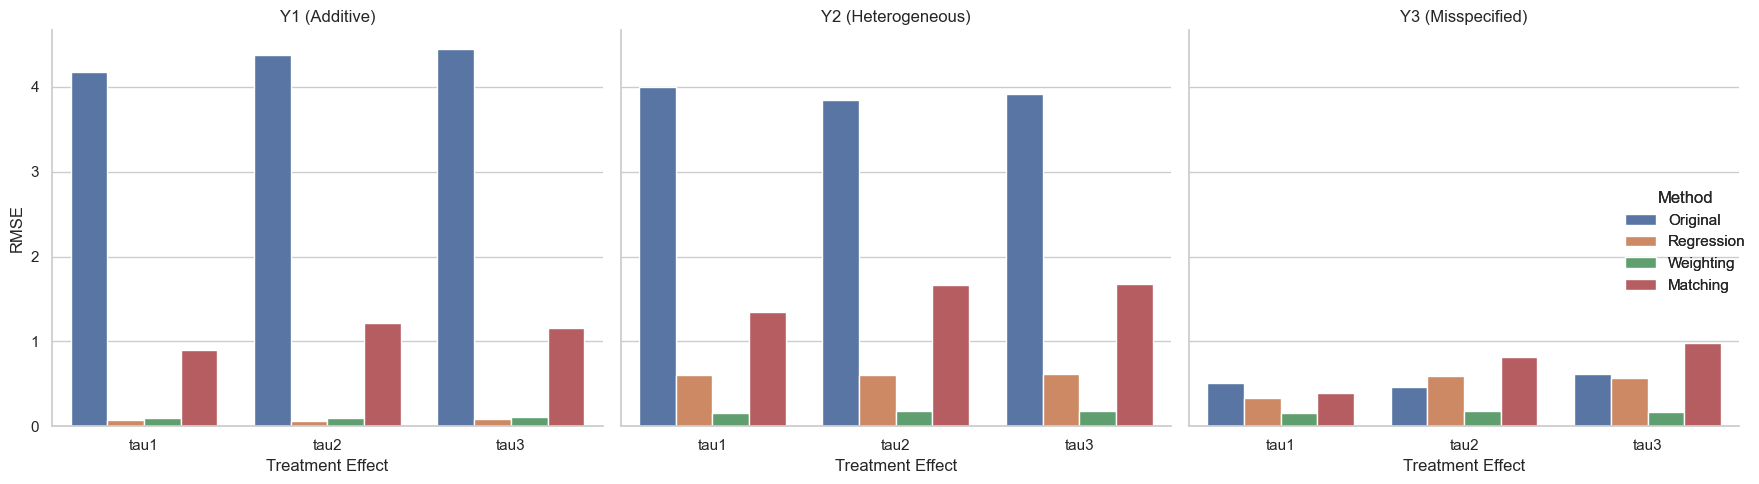

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_19583/502685.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_ess = sns.catplot(


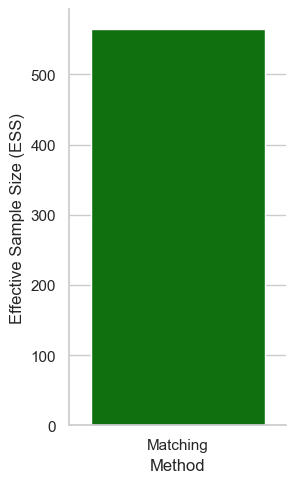

In [61]:
def plot_all_simulation_results(simulation_dict):
    sns.set(style="whitegrid")

    # === RMSE PLOT ===
    rmse_results = simulation_dict["rmse"]
    effects = ['tau1', 'tau2', 'tau3']
    methods_rmse = [
        "rmse_orig", "rmse_het_regression", "rmse_het_weighting", "rmse_het_matching"
    ]
    method_names_rmse = ["Original", "Regression", "Weighting", "Matching"]
    models = {
        "additive": "Y1 (Additive)",
        "heterogeneous": "Y2 (Heterogeneous)",
        "misspecified": "Y3 (Misspecified)"
    }

    data_rmse = []
    for model_type, res in rmse_results.items():
        for method_key, mname in zip(methods_rmse, method_names_rmse):
            rmse_values = res[method_key]  # shape (3,)
            for i, eff in enumerate(effects):
                data_rmse.append([models[model_type], eff, rmse_values[i], mname])

    df_rmse = pd.DataFrame(data_rmse, columns=["Outcome Model", "Effect", "RMSE", "Method"])

    g_rmse = sns.catplot(
        data=df_rmse,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        height=5,
        aspect=1
    )
    g_rmse.set_axis_labels("Treatment Effect", "RMSE")
    g_rmse.set_titles("{col_name}")
    g_rmse.set_xticklabels(rotation=0)
    g_rmse.add_legend(title="Method")
    plt.tight_layout()
    plt.show()

    # # === ESS PLOT ===
    # ess_results = simulation_dict["ess"]
    # data_ess = [["ESS", "Matching", ess_results["mean_ess_het"]]]
    # df_ess = pd.DataFrame(data_ess, columns=["Metric", "Method", "ESS"])

    # g_ess = sns.catplot(
    #     data=df_ess,
    #     x="Method",
    #     y="ESS",
    #     kind="bar",
    #     height=5,
    #     aspect=0.6,
    #     palette=["green"]
    # )
    # g_ess.set_axis_labels("Method", "Effective Sample Size (ESS)")
    # g_ess.set_titles("{col_name}")
    # g_ess.add_legend()
    # plt.tight_layout()
    # plt.show()

plot_all_simulation_results(simulation_dict)

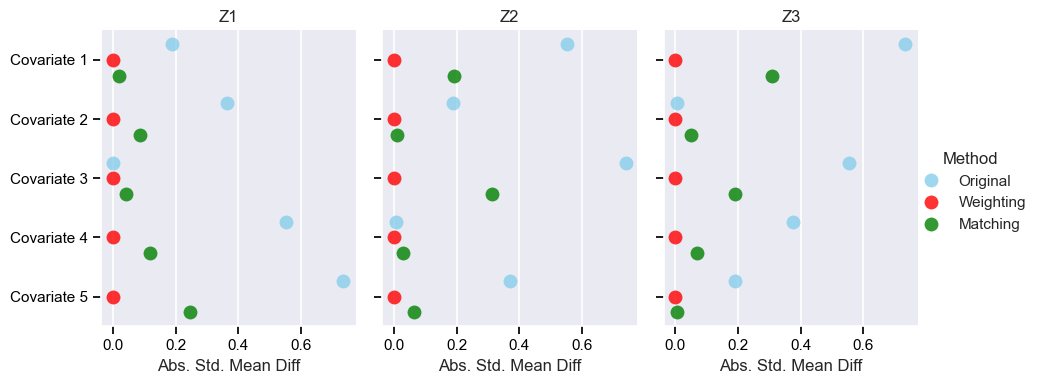

In [62]:
def plot_smd_by_treatment_group(smd_dict):
    """
    Plot SMDs faceted by treatment groups (Z combinations),
    showing original, weighting, and matching SMDs.
    Legend is outside and properly aligned without too much empty space.
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from itertools import product

    covariate_names = [f"Covariate {i+1}" for i in range(smd_dict["orig"].shape[1])]
    methods = {
        "orig": "Original",
        "het_weighting": "Weighting",
        "het_matching": "Matching"
    }

    data = []
    for k in range(3):  # Z1, Z2, Z3
        for d in range(len(covariate_names)):
            for method_key, method_name in methods.items():
                smd_vals = smd_dict[method_key]  # shape (3, D)
                data.append({
                    "Treatment": f"Z{k+1}",
                    "Covariate": covariate_names[d],
                    "Method": method_name,
                    "SMD": abs(smd_vals[k, d])
                })

    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    sns.set_theme(
    style="ticks",  # Similar to the reference background
    rc={
        "axes.facecolor": "#EAEAF2",  # Light gray panel
        "axes.edgecolor": "white",
        "axes.grid": True,
        "grid.color": "white",
        "grid.linewidth": 1.2,
        "xtick.color": "black",
        "ytick.color": "black"
    }
    )
    g = sns.catplot(
        data=df,
        x="SMD",
        y="Covariate",
        hue="Method",
        col="Treatment",
        kind="strip",
        dodge=True,
        height=4,
        aspect=0.8,
        palette={"Original": "skyblue", "Weighting": "red", "Matching": "green"},
        alpha=0.8,
        s=100,
        jitter=False,
        legend_out=True
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("Abs. Std. Mean Diff", "")

    # Reduce right spacing and pull legend a bit to the left
    g.fig.subplots_adjust(right=0.89)
   
plot_smd_by_treatment_group(simulation_dict["smd"])

### Apply to Data

Applying to the VOC data, I calculated the estimated main treatment effects and the 2-way interaction treatment effects of the weighting, matching and regression. I also calculated the SMDs for the original data, data after weighting and data after matching and plotted them out.

For the weighing and matching, I set the balancing interaction up to K-ways. The output of the weighting method is almost the same as the one in the paper. For the interaction(heterogeneous) regression, I included Y = X + Z + Z interactions up to K-way + Covariate-treatment interactions X_j * Z_k, but the estimated treatment effects is very different from the paper. 

The SMDs for some covariates in the matching method are worse than the original data.

In [3]:
def interaction_regression_het(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]

    design_list = [np.ones(N)]                            
    design_list += [X[:, j] for j in range(D)]            
    design_list += [Z[:, k] for k in range(K)]           

    # Z interactions up to K-way
    interaction_terms = []
    interaction_labels = []
    for r in range(2, K + 1):
        for J in combinations(range(K), r):
            term = Z[:, J[0]]
            for k in J[1:]:
                term = term * Z[:, k]
            interaction_terms.append(term)
            interaction_labels.append(tuple(k + 1 for k in J))  # for readable keys

    design_list += interaction_terms

    # Covariate-treatment interactions X_j * Z_k
    het_effect_labels = []
    for j in range(D):
        for k in range(K):
            design_list.append(X[:, j] * Z[:, k])
            het_effect_labels.append((j + 1, k + 1))

    X_design = np.column_stack(design_list)
    model = sm.OLS(Y, X_design).fit()
    coefs = model.params

    # Parse coefficient estimates
    ptr = 1 + D  # Start after intercept and X

    main_effects = {}
    for k in range(K):
        main_effects[k + 1] = 2 * coefs[ptr]
        ptr += 1

    interaction_2way = {}
    interaction_higher = {}
    for label, _ in zip(interaction_labels, interaction_terms):
        scale = 2 ** len(label)
        if len(label) == 2:
            interaction_2way[label] = scale * coefs[ptr]
        else:
            interaction_higher[label] = scale * coefs[ptr]
        ptr += 1

    het_effects = {}
    for label in het_effect_labels:
        het_effects[label] = 2 * coefs[ptr]
        ptr += 1

    return main_effects, interaction_2way

def estimate_main_and_2way_effects_weighted(Y, Z, w):
    N = len(Y)
    K = Z.shape[1]
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    tau_main = {}
    for k in range(K):
        tau_plus = np.sum(w * Aplus[:, k] * Y) / N
        tau_minus = np.sum(w * Aminus[:, k] * Y) / N
        tau_main[k + 1] = tau_plus - tau_minus

    tau_2way = {}
    for i, j in combinations(range(K), 2):
        zz = Z[:, i] * Z[:, j]
        pos_mask = (zz == 1)
        neg_mask = (zz == -1)

        if np.sum(pos_mask) < 1 or np.sum(neg_mask) < 1:
            tau_2way[(i + 1, j + 1)] = np.nan
        else:
            y_pos = np.sum(w[pos_mask] * Y[pos_mask]) / N
            y_neg = np.sum(w[neg_mask] * Y[neg_mask]) / N
            tau_2way[(i + 1, j + 1)] = y_pos - y_neg

    return tau_main, tau_2way

def estimate_main_and_2way_effects_original(Y, Z):
    K = Z.shape[1]
    tau_main = {}
    for k in range(K):
        plus = (Z[:, k] == +1)
        minus = (Z[:, k] == -1)
        if np.sum(plus) < 1 or np.sum(minus) < 1:
            tau_main[k + 1] = np.nan
        else:
            tau_main[k + 1] = np.mean(Y[plus]) - np.mean(Y[minus])

    tau_2way = {}
    for i, j in combinations(range(K), 2):
        zz = Z[:, i] * Z[:, j]
        pos = (zz == 1)
        neg = (zz == -1)
        if np.sum(pos) < 1 or np.sum(neg) < 1:
            tau_2way[(i + 1, j + 1)] = np.nan
        else:
            tau_2way[(i + 1, j + 1)] = np.mean(Y[pos]) - np.mean(Y[neg])
    return tau_main, tau_2way

def estimate_main_and_2way_effects_matched(Y, Z, match_vec):
    K = Z.shape[1]
    tau_main = {}
    for k in range(K):
        plus = (Z[:, k] == +1) & (match_vec == 1)
        minus = (Z[:, k] == -1) & (match_vec == 1)
        if np.sum(plus) < 1 or np.sum(minus) < 1:
            tau_main[k + 1] = np.nan
        else:
            tau_main[k + 1] = np.mean(Y[plus]) - np.mean(Y[minus])

    tau_2way = {}
    for i, j in combinations(range(K), 2):
        zz = Z[:, i] * Z[:, j]
        pos = (zz == +1) & (match_vec == 1)
        neg = (zz == -1) & (match_vec == 1)
        if np.sum(pos) < 1 or np.sum(neg) < 1:
            tau_2way[(i + 1, j + 1)] = np.nan
        else:
            tau_2way[(i + 1, j + 1)] = np.mean(Y[pos]) - np.mean(Y[neg])
    return tau_main, tau_2way


def get_2way_smds(X, Z, method="original", weights=None, selection=None):
    K = Z.shape[1]
    D = X.shape[1]
    L = K * (K - 1) // 2
    smd = np.zeros((L, D))
    sd_X = np.std(X, axis=0, ddof=1)

    pairs = list(combinations(range(K), 2))
    for idx, (i, j) in enumerate(pairs):
        Z_pair = Z[:, i] * Z[:, j]
        plus_mask = (Z_pair == +1)
        minus_mask = (Z_pair == -1)

        if method == "weighted" and weights is not None:
            w_plus = weights[plus_mask]
            w_minus = weights[minus_mask]
            mean_plus = np.average(X[plus_mask], axis=0, weights=w_plus) if w_plus.sum() > 0 else np.zeros(D)
            mean_minus = np.average(X[minus_mask], axis=0, weights=w_minus) if w_minus.sum() > 0 else np.zeros(D)
        elif method == "matched" and selection is not None:
            mask_plus = plus_mask & (selection == 1)
            mask_minus = minus_mask & (selection == 1)
            mean_plus = X[mask_plus].mean(axis=0) if mask_plus.sum() > 0 else np.zeros(D)
            mean_minus = X[mask_minus].mean(axis=0) if mask_minus.sum() > 0 else np.zeros(D)
        else:
            mean_plus = X[plus_mask].mean(axis=0) if plus_mask.sum() > 0 else np.zeros(D)
            mean_minus = X[minus_mask].mean(axis=0) if minus_mask.sum() > 0 else np.zeros(D)

        smd[idx, :] = (mean_plus - mean_minus) / (sd_X + 1e-15)

    return smd

def prepare_smd_plot_df_with_2way(smd_orig, smd_weighted, smd_matched, covariate_names, treatment_names, include_2way=True):
    rows = []
    D = smd_orig.shape[1]
    K = len(treatment_names)

    # Add main effects
    for k in range(K):
        for d in range(D):
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_orig[k, d]), "Category": "Original"})
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_weighted[k, d]), "Category": "Weighted"})
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_matched[k, d]), "Category": "Matched"})

    # Add 2-way interactions
    if include_2way:
        pairs = list(combinations(range(K), 2))
        for p, (i, j) in enumerate(pairs):
            label = f"{treatment_names[i]}: {treatment_names[j]}"
            for d in range(D):
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_orig[K + p, d]), "Category": "Original"})
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_weighted[K + p, d]), "Category": "Weighted"})
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_matched[K + p, d]), "Category": "Matched"})

    return pd.DataFrame(rows)

def plot_smd_faceted_with_yaxis_ticks(df_smd):
    sns.set(style="whitegrid")
    
    # Consistent order for categories and covariates
    category_order = ["Original", "Weighted", "Matched"]
    covariate_order = sorted(df_smd["Covariate"].unique())[::-1]  # from top to bottom

    # Initialize the facet grid
    g = sns.FacetGrid(
        df_smd,
        col="Treatment",
        col_wrap=3,
        sharex=True,
        sharey=True,
        height=3,
        aspect=1.3
    )

    # Use stripplot with dodge but no jitter, align to covariates
    g.map_dataframe(
        sns.stripplot,
        x="SMD",
        y="Covariate",
        hue="Category",
        hue_order=category_order,
        order=covariate_order,
        dodge=True,
        jitter=False,
        size=6,
        marker="o",
        palette={"Original": "deepskyblue", "Weighted": "firebrick", "Matched": "seagreen"}
    )

    # Add horizontal grid lines
    for ax in g.axes.flat:
        ax.yaxis.grid(True)
        ax.set_axisbelow(True)

    g.set_titles("{col_name}")
    g.set_xlabels("Abs. Std. Mean Diff")
    g.set_ylabels("Covariate")
    g.set(yticks=np.arange(len(covariate_order)), yticklabels=covariate_order)

    # Clean up legend
    g.add_legend(title="Category", bbox_to_anchor=(1.05, 0.5), loc="center left")
    plt.tight_layout()
    plt.show()


def run_plot_with_2way_smd(X, Z, weights, match_vec, covariate_names, treatment_names):
    smd_main_orig = get_covariate_balance_matched(X, Z, np.ones(X.shape[0]))
    smd_main_weighted = get_covariate_balance(X, Z, weights)
    smd_main_matched = get_covariate_balance_matched(X, Z, match_vec)

    smd_2way_orig = get_2way_smds(X, Z, method="original")
    smd_2way_weighted = get_2way_smds(X, Z, method="weighted", weights=weights)
    smd_2way_matched = get_2way_smds(X, Z, method="matched", selection=match_vec)

    smd_unweighted_all = np.vstack([smd_main_orig, smd_2way_orig])
    smd_weighted_all = np.vstack([smd_main_weighted, smd_2way_weighted])
    smd_matched_all = np.vstack([smd_main_matched, smd_2way_matched])

    df_smd = prepare_smd_plot_df_with_2way(
        smd_unweighted_all,
        smd_weighted_all,
        smd_matched_all,
        covariate_names=covariate_names,
        treatment_names=treatment_names,
        include_2way=True
    )

    plot_smd_faceted_with_yaxis_ticks(df_smd)


--- Weighting ---
  τ_1 = -0.3364
  τ_2 = 1.6753
  τ_3 = -0.2913
  τ_4 = 2.2472
  τ_(1, 2) = 0.4386
  τ_(1, 3) = 1.7344
  τ_(1, 4) = -0.4480
  τ_(2, 3) = -1.7313
  τ_(2, 4) = -0.0774
  τ_(3, 4) = -1.5086
--- Matching ---
  τ_1 = 0.4626
  τ_2 = -0.4348
  τ_3 = -0.4666
  τ_4 = 1.0977
  τ_(1, 2) = 1.4052
  τ_(1, 3) = 0.9548
  τ_(1, 4) = -0.7759
  τ_(2, 3) = 0.3406
  τ_(2, 4) = -1.9843
  τ_(3, 4) = -1.0535
--- Regression ---
  τ_1 = -0.6540
  τ_2 = -2.7318
  τ_3 = 1.5245
  τ_4 = -0.1741
  τ_(1, 2) = 2.2081
  τ_(1, 3) = 1.4627
  τ_(1, 4) = -0.8254
  τ_(2, 3) = -2.4067
  τ_(2, 4) = -1.9215
  τ_(3, 4) = -2.0830

=== Covariate Balance: Standardized Mean Differences (SMD) ===
Factor 1:
  Original:  [ 1.30192565 -0.32144114  0.14879957  0.010816    0.24279224  0.0468037 ]
  Weighted:  [ 6.24326073e-15 -5.71117825e-15  3.90982185e-15  1.35973419e-15
 -1.88553175e-15  1.19349614e-14]
  Matched :  [0.50368717 0.14380597 0.28685842 0.13252022 0.20622652 0.20167711]

Factor 2:
  Original:  [ 0.020491

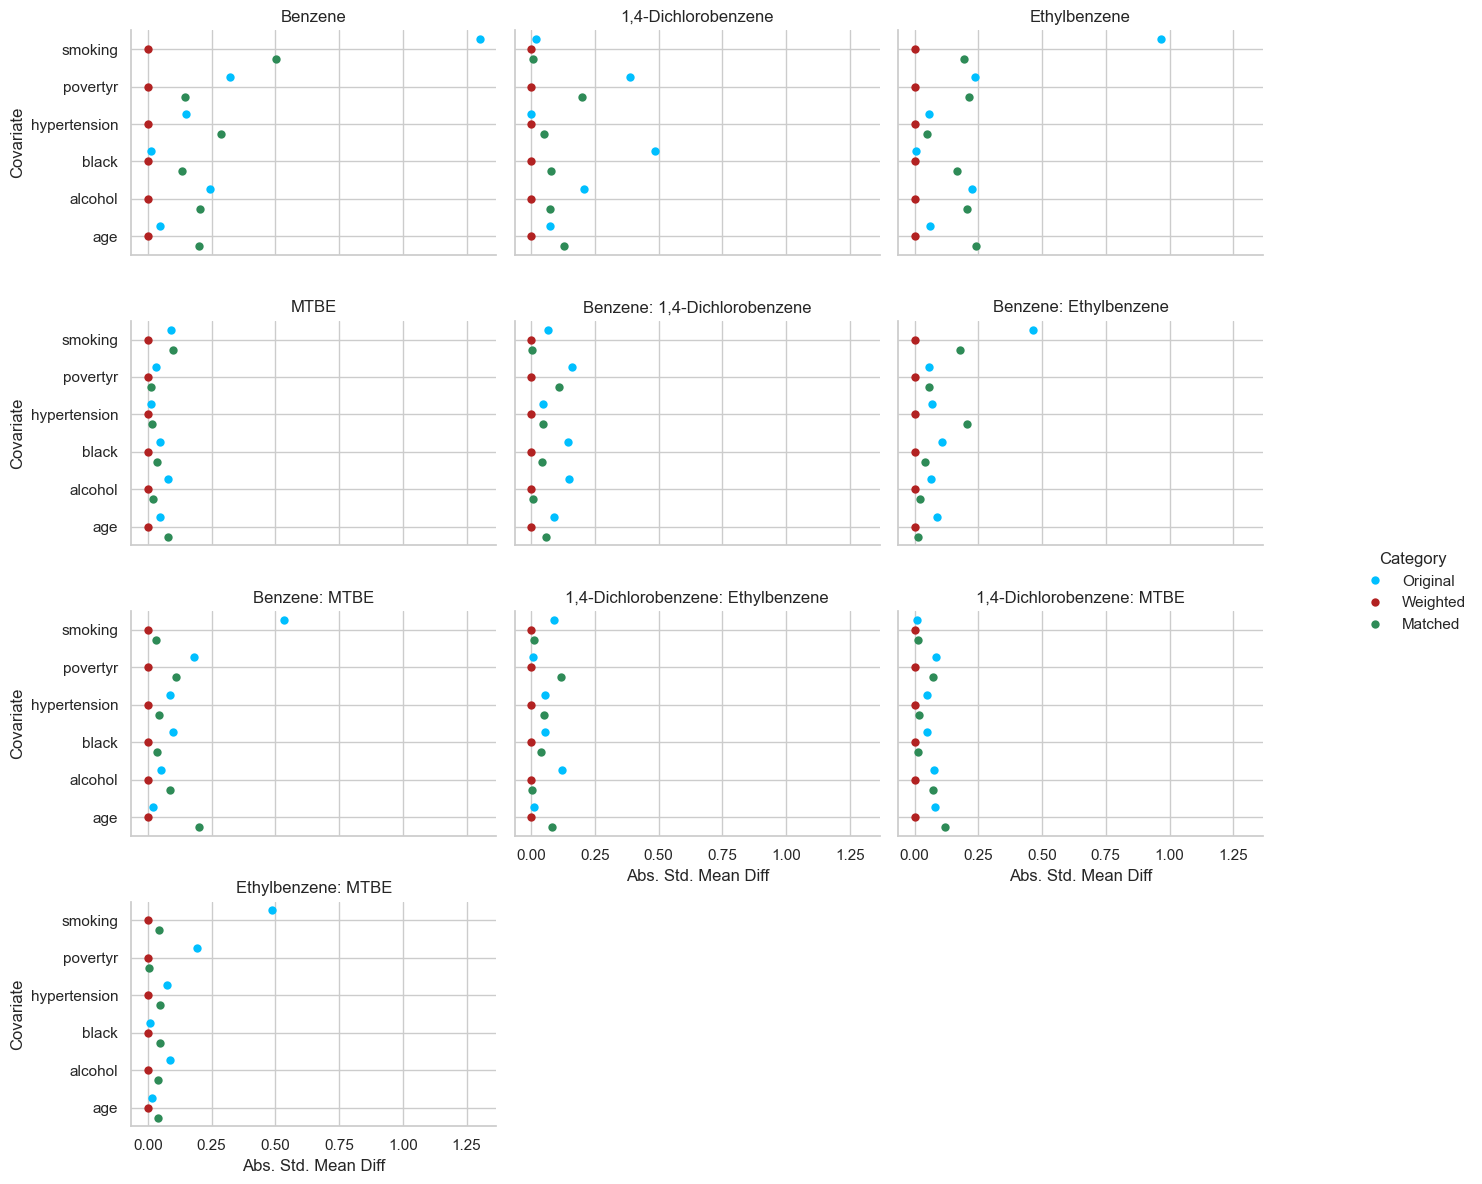

In [18]:

def main():
    data = pd.read_csv("/Users/zengyx/Desktop/voc_hr.csv")

    treatment_cols = ["benzene", "dichlorobenzene", "ethylbenzene", "mtbe"]
    outcome_col = "heartrate"

    # Preprocessing
    for col in treatment_cols:
        data[col] = data[col].map({0: -1, 1: +1})
        
    for col in ["black", "hispanic", "alcohol", "smoking", "hypertension"]:
        data[col] = data[col].astype(int)

    covariate_cols = ["smoking", "povertyr", "hypertension", "black", "alcohol", "age"]

    Z = data[treatment_cols].values.astype(int)
    X = data[covariate_cols].values.astype(float)
    Y = data[outcome_col].values.astype(float)
    N = X.shape[0]  
    D = X.shape[1]  
    K = Z.shape[1]  

    smd_unweighted = get_covariate_balance_matched(X, Z, np.ones(N))

    weights = solve_weights_heterogeneous(X, Z)
    smd_weighted = get_covariate_balance(X, Z, weights)

    match_vec = solve_matching_heterogeneous(X, Z, lambda_penalty=10000.0)
    smd_matched = get_covariate_balance_matched(X, Z, match_vec)

    tau_main_w, tau_2way_w = estimate_main_and_2way_effects_weighted(Y, Z, weights)
    tau_main_m, tau_2way_m = estimate_main_and_2way_effects_matched(Y, Z, match_vec)
    tau_main_r, tau_2way_r = interaction_regression_het(Y, X, Z)

    print("--- Weighting ---")
    for k in sorted(tau_main_w): print(f"  τ_{k} = {tau_main_w[k]:.4f}")
    for k in sorted(tau_2way_w): print(f"  τ_{k} = {tau_2way_w[k]:.4f}")

    print("--- Matching ---")
    for k in sorted(tau_main_m): print(f"  τ_{k} = {tau_main_m[k]:.4f}")
    for k in sorted(tau_2way_m): print(f"  τ_{k} = {tau_2way_m[k]:.4f}")

    print("--- Regression ---")
    for k in sorted(tau_main_r): print(f"  τ_{k} = {tau_main_r[k]:.4f}")
    for k in sorted(tau_2way_r): print(f"  τ_{k} = {tau_2way_r[k]:.4f}")

    print("\n=== Covariate Balance: Standardized Mean Differences (SMD) ===")
    for k in range(K):
        print(f"Factor {k+1}:")
        print(f"  Original: ", smd_unweighted[k])
        print(f"  Weighted: ", smd_weighted[k])
        print(f"  Matched : ", smd_matched[k])
        print("")

    run_plot_with_2way_smd(
        X, Z, weights, match_vec,
        covariate_names=["smoking", "povertyr", "hypertension", "black", "alcohol", "age"],
        treatment_names=["Benzene", "1,4-Dichlorobenzene", "Ethylbenzene", "MTBE"]
    )


if __name__ == "__main__":
    main()

## Setup 2

### Approach:


I stratified the selected samples into several groups (strata) and within each stratum, and I want the distribution of covariates is balanced across treatment levels with in each strata. The method forces that, within each stratum, the contrast of treatment effects of the covariates for units receiving “+1” and “–1” treatments to be very similar (with a slack variable). 

I start with a dataset of N selected units, each with 5 covariates (stored in X) and a set of 3 treatment indicators (stored in Z, with entries either +1 or –1). The goal is to assign every unit to one of a fixed number of strata (S strata) such that within each stratum the covariate distributions between the treatment groups (for each factor and for interactions like the ones in the balancing weight method) of +1 and -1 are similar.

##### Decision Variables:
Let:
- $N$: Number of units
- $D$: Number of covariates
- $K$: Number of treatment factors
- $S$: Number of strata (fixed)


For each unit $i$ = 1, $\dots$, N and stratum $s$ = 1, $\dots$, S, define:
$$
S_{i,s} \in \{0, 1\}
$$
- $S_{i,s}$ = 1 if unit $i$ is assigned to stratum $s$.
- Constraint: Each unit is assigned to exactly one stratum:
$
\sum_{s=1}^{S} S_{i,s} = 1 \quad \forall i
$


Slack variables allow relaxed constraints:
- For each balancing constraint, introduce slack variable to loose the constraints

##### Balancing constraints per stratum (with slack):

Let $ A_{i,k}^+ = \mathbb{1}\{Z_{i,k} = +1\}$, $\quad A_{i,k}^- = \mathbb{1}\{Z_{i,k} = -1\}$

I impose for all $ k = 1,\dots,K $, all basis $ s $, all interaction sets $ J $, and all strata $ r = 1,\dots,S $:
$$
\sum_{i=1}^N S_{i,r} \cdot (A_{i,k}^+ - A_{i,k}^-) \cdot q_{sJ}(\mathbf{X}_i, \mathbf{Z}_i) = t_{k,s,J,r}^{+} - t_{k,s,J,r}^{-}
$$

##### Objective: Minimize the total imbalance across all strata and basis/interaction terms:
$$
\min_{S, t} \lambda \sum_{k,s,J,r} \left( t_{k,s,J,r}^{+} + t_{k,s,J,r}^{-} \right)
$$



In [6]:
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

def solve_strata_hetero(X, Z, num_strata=5, lambda_penalty=100.0):
    model = gp.Model("StrataHeteroAbsDiff_slack")
    model.setParam('OutputFlag', 0)
    
    N, D = X.shape
    K = Z.shape[1]

    # === 1. Strata assignment variables ===
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
    U = model.addVars(num_strata, vtype=GRB.BINARY, name="U")

    for s in range(num_strata):
        model.addConstr(gp.quicksum(S[i, s] for i in range(N)) >= 1 - (1 - U[s]) * N)
        model.addConstr(gp.quicksum(S[i, s] for i in range(N)) <= U[s] * N)
    model.addConstr(gp.quicksum(U[s] for s in range(num_strata)) == num_strata, name="force_all_strata_used")

    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1, name=f"assign_unit_{i}")

    # === 2. Build basis functions and interactions ===
    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    # Main, 2-way, and 3-way interactions
    J_list = [()]
    for r in range(1, K+1):
        J_list += list(combinations(range(K), r))
        
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.ones(N) if len(J) == 0 else np.prod(Z[:, list(J)], axis=1)
        for s_idx in range(n_s):
            Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # === 3. Add balancing constraints (with slack) per stratum ===
    slack_vars = []
    for k in range(K):
        for s_idx in range(n_s):
            for j_idx in range(n_J):
                for s in range(num_strata):
                    t_pos = model.addVar(lb=0.0, name=f"tpos_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    t_neg = model.addVar(lb=0.0, name=f"tneg_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    slack_vars.extend([t_pos, t_neg])

                    lhs_diff = gp.quicksum(S[i, s] * (Aplus[i, k] - Aminus[i, k]) * Qvals[i, s_idx, j_idx] for i in range(N))
                    model.addConstr(lhs_diff == t_pos - t_neg, name=f"imbalance_k{k}_s{s_idx}_j{j_idx}_s{s}")

    # === 4. Objective: minimize total imbalance slack ===
    obj = lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Infeasible or no optimal solution found.")
        return None, None

    strata_assign = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                strata_assign[i] = s
                break

    return strata_assign, model.ObjVal

def estimate_main_effects_strata(Y, Z, strata):
    K = Z.shape[1]
    tau_est = {k+1: [] for k in range(K)}
    for s in np.unique(strata):
        idx = (strata == s)
        if np.sum(idx) < 2:
            continue
        for k in range(K):
            plus = (Z[idx, k] == 1)
            minus = (Z[idx, k] == -1)
            if np.sum(plus) < 1 or np.sum(minus) < 1:
                continue
            tau = np.mean(Y[idx][plus]) - np.mean(Y[idx][minus])
            tau_est[k+1].append(tau)
    return tau_est


def run_simulation_matching_strata(n_sims=10, D=5, K=3, N=500, lambda_penalty=100.0, num_strata=5):
    outcome_models = {
        "additive": Y_model_additive,
        "heterogeneous": Y_model_het,
        "misspecified": Y_model_mis
    }

    slack_list = []
    rmse_summary = {model: [] for model in outcome_models}
    bias_summary = {model: [] for model in outcome_models}
    stratum_rmse_tracker = {model: {} for model in outcome_models}

    mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
    X = np.random.multivariate_normal(mu, Sigma, size=N)
    Z = generate_treatments(X)

    for sim in range(n_sims):
        matchH = solve_matching_heterogeneous(X, Z, lambda_penalty=1.0)
        if matchH is None:
            continue
        selected = np.flatnonzero(matchH > 0.5)
        Xsel, Zsel = X[selected], Z[selected]

        clusters, slack = solve_strata_hetero(Xsel, Zsel, num_strata=num_strata, lambda_penalty=lambda_penalty)
        if clusters is None:
            continue
        slack_list.append(slack)

        for model_name, Y_fn in outcome_models.items():
            Y = Y_fn(Xsel, Zsel)
            true_tau = true_main_effects(Y_fn, combos=Z_all)

            per_stratum_rmse = []
            per_stratum_bias = []

            for s in range(num_strata):
                idx = (clusters == s)
                if np.sum(idx) < 5:
                    continue
                Ys, Zs = Y[idx], Zsel[idx]
                tau_est = estimate_main_effects_strata(Ys, Zs, np.zeros_like(Ys))

                errs = []
                biases = []
                for k in range(K):
                    if len(tau_est[k+1]) == 0:
                        continue
                    m_tau = np.mean(tau_est[k+1])
                    err = (m_tau - true_tau[k+1]) ** 2
                    bias = m_tau - true_tau[k+1]
                    errs.append(err)
                    biases.append(bias)

                if errs:
                    rmse = np.sqrt(np.mean(errs))
                    bias = np.mean(biases)
                    per_stratum_rmse.append(rmse)
                    per_stratum_bias.append(bias)

                    if s not in stratum_rmse_tracker[model_name]:
                        stratum_rmse_tracker[model_name][s] = []
                    stratum_rmse_tracker[model_name][s].append(rmse)

            if per_stratum_rmse:
                rmse_summary[model_name].append(np.mean(per_stratum_rmse))
                bias_summary[model_name].append(np.mean(per_stratum_bias))

    print(f"Running for {num_strata} strata...")
    for model_name in outcome_models:
        strata_ids = sorted(stratum_rmse_tracker[model_name].keys())
        avg_rmse_per_stratum = [
            np.mean(stratum_rmse_tracker[model_name][s]) for s in strata_ids
        ]
        mean_of_stratum_rmses = np.mean(avg_rmse_per_stratum)
        rounded_list = [round(x, 4) for x in avg_rmse_per_stratum]
        print(f"[{model_name}] RMSEs per stratum: {rounded_list} → Mean RMSE: {mean_of_stratum_rmses:.4f}")

    return {
        "slack": slack_list,
        "avg_rmse": {m: np.mean(rmse_summary[m]) for m in outcome_models},
        "var_rmse": {m: np.var(rmse_summary[m]) for m in outcome_models},
        "avg_bias": {m: np.mean(bias_summary[m]) for m in outcome_models},
        "var_bias": {m: np.var(bias_summary[m]) for m in outcome_models},
    }


def plot_strata_simulation_results(strata_vals, results_by_strata):
    models = ["additive", "heterogeneous", "misspecified"]

    avg_slacks = [np.mean(r['slack']) for r in results_by_strata]
    rmse_variances = {m: [r['var_rmse'][m] for r in results_by_strata] for m in models}
    bias_variances = {m: [r['var_bias'][m] for r in results_by_strata] for m in models}
    avg_rmses = {m: [r['avg_rmse'][m] for r in results_by_strata] for m in models}

    plt.figure()
    plt.plot(strata_vals, avg_slacks, marker='o')
    plt.xlabel("Number of Strata")
    plt.ylabel("Average Total Slack")
    plt.title("Slack vs Number of Strata")
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, rmse_variances[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Variance of RMSE")
    plt.title("Variance of RMSE by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, bias_variances[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Variance of Bias")
    plt.title("Variance of Bias by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, avg_rmses[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Average RMSE (Per-Stratum Averaged)")
    plt.title("Average RMSE by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()



In [3]:
def main():
    np.random.seed(123)
    D = 5 
    K = 3
    n_sims = 1
    N = 200
    lambda_penalty = 1
    strata_vals = list(range(2, 9))  # 2 to 8 strata

    results_by_strata = []
    print("\n==== Starting Strata Simulation ====\n")

    for num_strata in strata_vals:
        result = run_simulation_matching_strata(
            n_sims=n_sims, D=D, K=K, N=N,
            lambda_penalty=lambda_penalty, num_strata=num_strata
        )
        results_by_strata.append(result)

    print("\n==== Completed All Strata Levels ====")
    plot_strata_simulation_results(strata_vals, results_by_strata)


if __name__ == "__main__":
    main()


==== Starting Strata Simulation ====

Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
Running for 2 strata...
[additive] RMSEs per stratum: [np.float64(1.0515), np.float64(0.6666)] → Mean RMSE: 0.8590
[heterogeneous] RMSEs per stratum: [np.float64(0.79), np.float64(0.7406)] → Mean RMSE: 0.7653
[misspecified] RMSEs per stratum: [np.float64(0.2577), np.float64(0.2303)] → Mean RMSE: 0.2440
